### Generate Embeddings

This notebook process the selection of repreentative links and generates the embeddings from these

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import pyproj
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon, MultiLineString
from shapely.ops import transform
import folium

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# prevent tensorflow from allocating the entire GPU memory at once
sess = tf.get_default_session()
# close current session
if sess is not None:
    sess.close()
# reset graph
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.InteractiveSession(config=config)
K.set_session(sess)

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('geopandas', gpd.__version__)

print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

print('pyproj', pyproj.__version__)
print('shapely', shapely.__version__)
print('folium', folium.__version__)

print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)

numpy 1.16.2
pandas 1.0.0
geopandas 0.6.2
tensorflow ver.: 1.13.1
keras ver.: 2.2.4-tf
pyproj 1.9.5.1
shapely 1.6.4.post2
folium 0.10.0
matplotlib 3.0.3
seaborn 0.9.0


### Selecting representative time series

Here we load the calendar data:

In [4]:
cal = pd.read_csv('../data_input/calendar.csv', parse_dates=True, index_col=0)
cal_train = cal['2016-01-01':'2018-12-31']
cal_test = cal['2019-01-01':'2019-04-30']

X_ix, X_lab = cal['DayType'].factorize()

Here we only load $\mathbf{M^\textit{ln}}$ for $C^\textit{ln} > 70\%$

In [5]:
link_travel_time_1h = pd.concat([
    pd.read_csv('../data_input/matrix_2016.csv.gz', parse_dates=True),
    pd.read_csv('../data_input/matrix_2017.csv.gz', parse_dates=True),
    pd.read_csv('../data_input/matrix_2018.csv.gz', parse_dates=True),
])
link_travel_time_1h['Date'] = pd.to_datetime(link_travel_time_1h['Date'])
link_candidates = np.unique(link_travel_time_1h['LinkRef'])

Number of links (for $C^\textit{ln} > 70\%$)

In [6]:
len(link_candidates)

1486

We apply KNN imputation and PELT-algoritm to yeild $\mathbf{\widehat{M}}^\textit{ln}$ and $R^\textit{ln}$

In [7]:
import ruptures as rpt
from sklearn.impute import KNNImputer

In [8]:
link_travel_time_1h_sorted = link_travel_time_1h.set_index(['LinkRef', 'Date', 'Hour']).sort_index()

In [39]:
def calc_change_points(link_travel_time_matrix, cal, impute = True):
    if impute:
        imputer = KNNImputer(n_neighbors=5)
        link_travel_time_matrix = pd.DataFrame(
            imputer.fit_transform(link_travel_time_matrix.values),
            index = link_travel_time_matrix.index,
            columns = link_travel_time_matrix.columns
        )
    
    link_travel_time_day = link_travel_time_matrix.dropna().mean(axis = 1)
    coverage = len(link_travel_time_day) / len(cal)
    
    algo = rpt.Pelt(model="rbf").fit(link_travel_time_day.values)
    result = algo.predict(pen=10)
    
    return link_travel_time_day, coverage, result

def process_link(link_ref):
    link_travel_time_matrix = link_travel_time_1h_sorted.loc[link_ref, 'LinkTravelTimeMean'].unstack(1)
    imputed, coverage, change_points = calc_change_points(link_travel_time_matrix, cal_train)
    return {
        'link_ref': link_ref,        
        'imputed': imputed,
        'coverage': coverage,
        'change_points': change_points,
        'change_point_count': len(change_points)
    }

We apply the processing in parallel on all CPUs:

In [40]:
import multiprocessing as mp
import tqdm
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [41]:
pool = mp.Pool(mp.cpu_count())
results = []
for _ in tqdm.tqdm(pool.imap_unordered(process_link, link_candidates), total=len(link_candidates)):
    results.append(_)
pool.close()

100%|██████████| 1486/1486 [06:34<00:00,  3.77it/s]


Create a lookup map, and save results for later: 

In [68]:
import pickle
results_lookup = {x['link_ref']: x for x in results}
with open('../output/matrix_imputed.pickle', 'wb') as f:
    pickle.dump(results_lookup, f)

### Embeddings model

In [69]:
if not results_lookup:
    with open('../output/matrix_imputed.pickle', 'rb') as f:
        results_lookup = pickle.load(f)

In [73]:
for link_ref, v in results_lookup.items():
    links_current.loc[link_ref, 'change_point_count'] = v['change_point_count']
    links_current.loc[link_ref, 'coverage'] = v['coverage']

Load test data (2019)

In [84]:
link_travel_time_1h_test = pd.read_csv('../data_input/matrix_2019.csv.gz', parse_dates=True)
link_travel_time_1h_test['Date'] = pd.to_datetime(link_travel_time_1h_test['Date'])

In [94]:
link_travel_time_1h_test_sorted = link_travel_time_1h_test.set_index(['LinkRef', 'Date', 'Hour']).sort_index()

Select representative links based on $\beta$ and $\gamma$

In [85]:
gamma = 1
beta = 0.95
representative_links = [k for k, v in results_lookup.items() if (v['change_point_count'] <= gamma) and (v['coverage'] > beta)]

In [86]:
len(representative_links)

70

In [88]:
def build_link_travel_time_tensors(link_travel_time_sorted, cal, link_refs):
    mat_imputed_ls = []
    weight_ls = []

    for link_ref in link_refs:
        mat = link_travel_time_sorted.loc[link_ref]['LinkTravelTimeMean'].unstack(1).sort_index(axis = 1)
        weight = link_travel_time_sorted.loc[link_ref]['DataPointCount'].unstack(1).sort_index(axis = 1).fillna(0)

        mu_ln = np.nanmean(mat.values).round(1)
        
        imputer = KNNImputer(n_neighbors=5)
        mat_imputed = pd.DataFrame(
            imputer.fit_transform(mat.values),
            index = mat.index,
            columns = mat.columns
        )

        mat_imputed = mat_imputed.reindex(cal.index, fill_value = mu_ln)
        mat_imputed = mat_imputed.reindex(np.arange(24), axis = 1, fill_value = mu_ln)
        weight = weight.reindex(cal.index, fill_value = 0)
        weight = weight.reindex(np.arange(24), axis = 1, fill_value = 0)

        mat_imputed_ls.append(mat_imputed.values)
        weight_ls.append(weight)
        
    Y = np.stack(mat_imputed_ls, axis = 2)
    W = np.stack(weight_ls, axis = 2)
    return Y, W

In [93]:
X_train = X_ix[cal.index.isin(cal_train.index)]
Y_train, W_train = build_link_travel_time_tensors(link_travel_time_1h_sorted, cal_train, representative_links)
print('X_train', X_train.shape)
print('Y_train', Y_train.shape)
print('W_train', W_train.shape)

X_train (1096,)
Y_train (1096, 24, 70)
W_train (1096, 24, 70)


In [95]:
X_test = X_ix[cal.index.isin(cal_test.index)]
Y_test, W_test = build_link_travel_time_tensors(link_travel_time_1h_test_sorted, cal_test, representative_links)
print('X_test', X_test.shape)
print('Y_test', Y_test.shape)
print('W_test', W_test.shape)

X_test (120,)
Y_test (120, 24, 70)
W_test (120, 24, 70)


In [611]:

curr_session = tf.get_default_session()
# close current session
if curr_session is not None:
    curr_session.close()
# reset graph
K.clear_session()
# create new session
s = tf.InteractiveSession()
K.set_session(s)

In [570]:
EMBEDDING_DIM = 4
N_TOD = 24
N_LINKS = len(golden_links)
N_DAYTYPE = len(X_lab)

import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred, weights):
    return K.mean(keras.backend.pow(y_true - y_pred, 2) * weights)

def zero_masked_mse(y_true, y_pred):
    mask = 1 - K.cast(K.equal(y_true, 0), dtype=K.floatx())
    return K.mean(keras.backend.pow(y_true - y_pred, 2) * mask)

input_day = keras.layers.Input(shape = (1, ), name = 'day')
input_weights = keras.layers.Input(shape = (N_TOD, N_LINKS), name = 'weights')

x = keras.layers.Embedding(N_DAYTYPE, EMBEDDING_DIM,
        #embeddings_regularizer=regularizers.l2(0.01),
        #activity_regularizer=regularizers.l1(0.01),
        name = 'embedding')(input_day)

x = keras.layers.Flatten(name = 'flat')(x)
x = keras.layers.Dense(units=N_LINKS*N_TOD, name = 'dense_1', activation = 'linear')(x)
x = keras.layers.Reshape((N_TOD, N_LINKS), name= 'reshape_1')(x)

output_1 = x

model = keras.Model(inputs=[input_day, input_weights], outputs=[output_1])
model.compile(
    optimizer=tf.train.RMSPropOptimizer(learning_rate = 1e-2, momentum = 0.75, decay = 0.95),
    loss=partial(weighted_mse, weights=input_weights))

In [571]:
#plot_model(model, 'model_embedding_simple_lr_link_model.png', show_shapes=True)

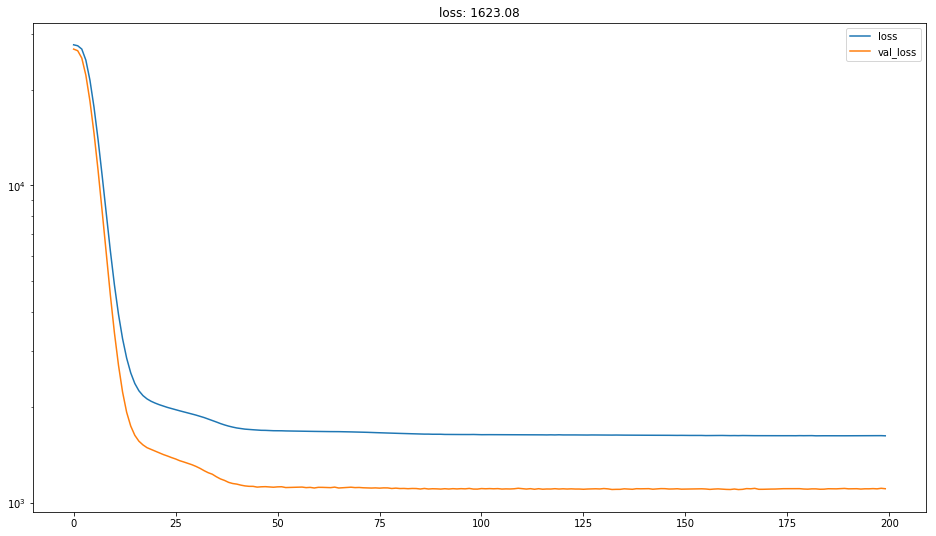

In [572]:

model.fit([X_train, W_train], [Y_train], batch_size=117, epochs=200, verbose=0, callbacks = [plot_losses], validation_data=[[X_test, W_test], [Y_test]])

In [582]:
Y_train_pred = model.predict([X_train, W_train]).round(1)
Y_test_pred = model.predict([X_test, W_test]).round(1)
Y_train_pred[W_train == 0] = Y_train[W_train == 0]
Y_test_pred[W_test == 0] = Y_test[W_test == 0]

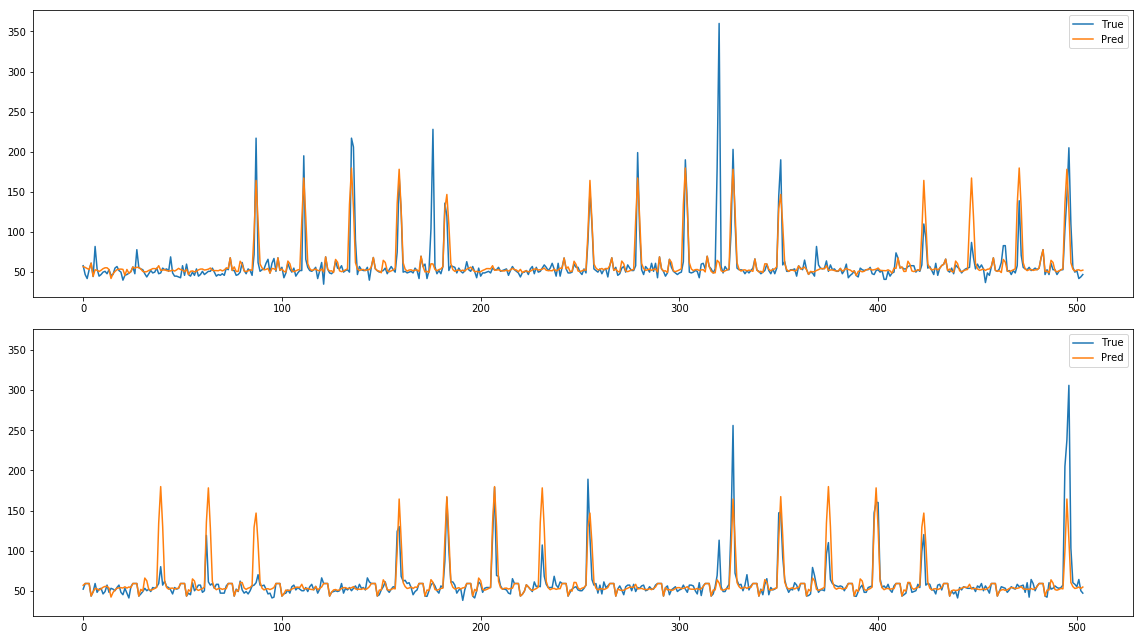

In [595]:
fig, ax = plt.subplots(figsize = (16, 9), nrows=2, sharey=True)
fig.tight_layout()

t_start = 0
t_end = 21
link_ix = 31

ax[0].plot(Y_train[:t_end, :, link_ix].reshape(-1), label = 'True')
ax[0].plot(Y_train_pred[:t_end, :, link_ix].reshape(-1), label = 'Pred')
ax[0].legend()

ax[1].plot(Y_test[:t_end, :, link_ix].reshape(-1), label = 'True')
ax[1].plot(Y_test_pred[:t_end, :, link_ix].reshape(-1), label = 'Pred')
ax[1].legend()

In [597]:
embedding_model = keras.Model(inputs=model.inputs[0], outputs=model.get_layer('embedding').output)
components = pd.DataFrame(
    data = embedding_model.predict(np.arange(len(X_lab)))[:,0,:],
index = X_lab)

In [598]:
components

,0,1,2,3
New Year's Day,4.890558,2.232660,-9.298495,0.787617
Saturday,6.838488,2.591834,-6.498434,-1.005326
Sunday,5.753662,2.941895,-7.806767,0.465665
Monday,1.129430,7.901644,-7.013516,-5.365285
Tuesday,2.988307,8.779336,-5.290000,-5.209229
Wednesday,4.466297,10.380355,-3.802029,-4.728890
Thursday,4.874319,10.091317,-3.155101,-5.546072
Friday,7.487285,8.322498,-1.856689,-5.773644
Winter Vacation,3.319950,2.475531,-6.991780,-5.268756
Pre Easter Monday,2.721979,2.270839,-6.242739,-7.841693


In [605]:
import gc

hist = None
model = None

tf.keras.backend.clear_session()
gc.collect()

In [609]:
tf.keras.backend.clear_session()

In [610]:
from numba import cuda
cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba'

In [600]:
def plot_mds(ax, mds, labels):
    from adjustText import adjust_text
    pal = sns.color_palette("hls", len(labels))
    texts = []
    for i, l in enumerate(labels):
        ax.scatter(mds[i, 0], mds[i, 1], color = pal[i], label = l)
        text = ax.text(mds[i, 0], mds[i, 1], l, ha='center', va='center')
        texts.append(text)
    adjust_text(texts)

Visualize loss on the map. 


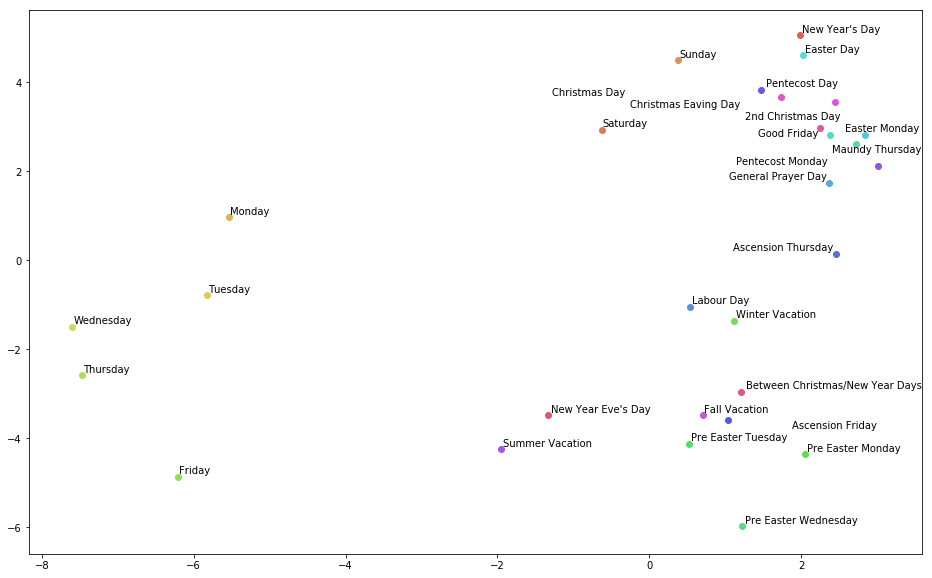

In [601]:
from sklearn import manifold
fig, ax = plt.subplots(figsize = (16, 10))
components_mds = manifold.MDS().fit_transform(components.values)
plot_mds(ax, components_mds, X_lab)

components.to_csv('../output/reference-link-embeddings.csv')